In [416]:
import requests
import pandas
import urllib.parse
from datetime import datetime
from matplotlib import pyplot
from IPython.display import display_markdown

pandas.set_option("display.max_colwidth", None)

phases = [
    "investigation",
    "construction",
    "acceleration",
    "transfer",
    "success",
    "alumni",
]
colors = ["#ffd17a", "#ff914d", "#fa6bbc", "#0bffb3", "#1fbcff", "#aaa"]

In [436]:
startups_details = [
    data
    for (key, data) in requests.get(
        "https://beta.gouv.fr/api/v2.6/startups_details.json"
    )
    .json()
    .items()
]
startups = [
    {"id": item.get("id"), **item.get("attributes"), **item.get("relationships")}
    for item in requests.get(
        "https://beta.gouv.fr/api/v2.6/startups.json"
    )
    .json()
    .get("data")
]
authors = requests.get("https://beta.gouv.fr/api/v2.6/authors.json").json()

In [418]:
print(f"Loaded {len(startups_details)} startups_details")
print(f"Loaded {len(startups)} startups")
print(f"Loaded {len(authors)} authors")

Loaded 514 startups_details
Loaded 514 startups
Loaded 2652 authors


In [439]:
# Cleanup some data
startups_df = pandas.DataFrame.from_dict(startups)


def phase_date_getter(phase):
    return datetime.fromisoformat(phase.get("start"))


#startups_df["stats_url"] = startups_df["stats_url"].fillna("")

startups_df["markdown"] = startups_df["content_url_encoded_markdown"].map(
    urllib.parse.unquote
)
startups_df = startups_df.drop(columns=["content_url_encoded_markdown"])

startups_df["phase"] = startups_df["phases"].apply(
    lambda x: sorted(x, key=phase_date_getter, reverse=True)[0].get("name")
)

startups_df["incubator"] = startups_df["incubator"].apply(
    lambda x: x.get("data", {}).get("id")
)

In [420]:
display_markdown(
    "## Aperçu des données",
    raw=True,
)

startups_df[["id", "name", "incubator", "phase", "contact", "stats_url"]].head(10)

## Aperçu des données

,id,name,incubator,phase,contact,stats_url
0,1-jeune-1-arbre,1 Jeune 1 Arbre,agriculture,investigation,melanie.briand@beta.gouv.fr,NaN
1,1000.jours,1000 premiers jours - l'app,sgmas,transfer,love.andrieu@social.gouv.fr,https://1000jours.fabrique.social.gouv.fr/stats
2,1000.premiers.jours.blues,1000 premiers jours Blues,sgmas,acceleration,contact-nos1000jours@fabrique.social.gouv.fr,https://1000jours-blues.fabrique.social.gouv.fr/stats
3,a-dock,A Dock,mtes,alumni,contact@adock.beta.gouv.fr,https://adock.beta.gouv.fr/stats
4,a-just,A-JUST,justice,acceleration,contact@a-just.fr,https://a-just.beta.gouv.fr/stats
5,acces.majeur.protege,Accès Majeur Protégé,justice,alumni,anne.devoret@beta.gouv.fr,NaN
6,acceslibre,Acceslibre,mtes,acceleration,acceslibre@beta.gouv.fr,https://acceslibre.beta.gouv.fr/stats
7,accesscite,Access'cité,mtes,construction,melanie.briand@beta.gouv.fr,NaN
8,accueil-telephonique-uts,Accueil UTS,anct,alumni,contactincubateur@anct.gouv.fr,NaN
9,aeris,Aeris,mtes,alumni,jacob.carbonel@beta.gouv.fr,NaN


In [429]:
startups_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    514 non-null    object
 1   name                  514 non-null    object
 2   pitch                 514 non-null    object
 3   contact               514 non-null    object
 4   events                514 non-null    object
 5   phases                514 non-null    object
 6   sponsors              514 non-null    object
 7   thematiques           514 non-null    object
 8   incubator             514 non-null    object
 9   stats_url             141 non-null    object
 10  link                  225 non-null    object
 11  repository            212 non-null    object
 12  dashlord_url          83 non-null     object
 13  accessibility_status  241 non-null    object
 14  analyse_risques       23 non-null     object
 15  budget_url            30 non-null     ob

## Startups par incubateur (hors alumni)

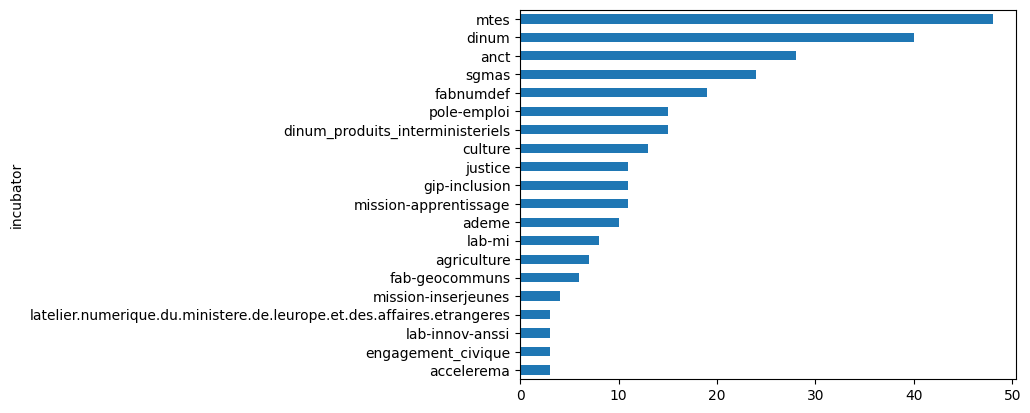

In [421]:
display_markdown(
    "## Startups par incubateur (hors alumni)",
    raw=True,
)
startups_df.query("phase != 'alumni'").groupby(
    "incubator", dropna=False
).size().sort_values().plot(
    kind="barh",
);


## Startups par incubateur et par phase (hors alumni)

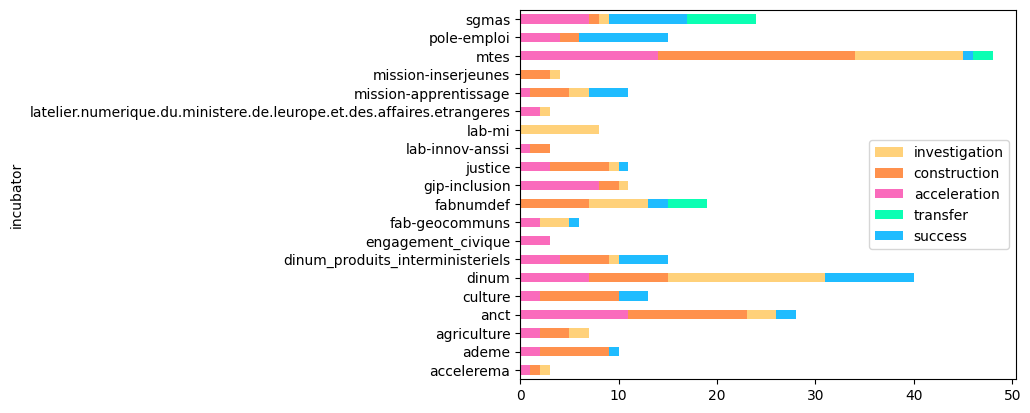

In [422]:
display_markdown(
    "## Startups par incubateur et par phase (hors alumni)",
    raw=True,
)
startups_df.query("phase != 'alumni'").groupby(
    ["incubator", "phase"], dropna=False
).size().sort_values(ascending=False).unstack(fill_value=0).plot(
    kind="barh",
    stacked=True,
)

# fix legend
handles, labels = pyplot.gca().get_legend_handles_labels()
sorted_order = [phases.index(x) for (i, x) in enumerate(labels)]
for i, handle in enumerate(handles):
    for bar in handle:
        color = colors[sorted_order[i]]
        bar.set_facecolor(color)
sorted_handles = [x for _, x in sorted(zip(sorted_order, handles))]
pyplot.legend(
    sorted_handles,
    sorted(labels, key=lambda x: phases.index(x)),
);

## Startups par thématique et par phase (hors alumni)

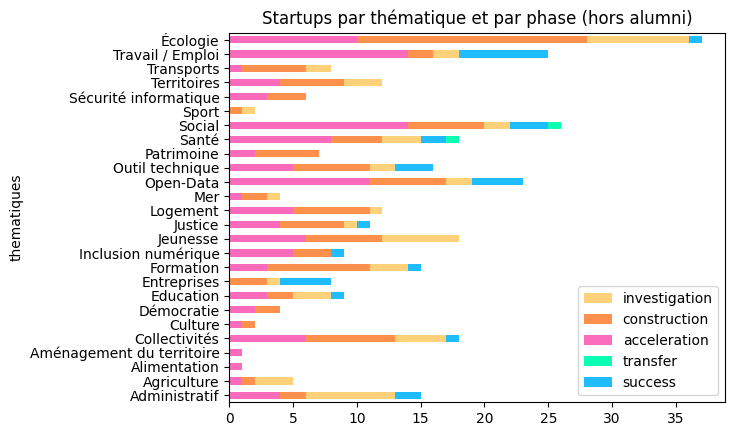

In [423]:
display_markdown(
    "## Startups par thématique et par phase (hors alumni)",
    raw=True,
)
startups_df_exploded = startups_df.query("phase != 'alumni'").explode("thematiques")
startups_df_exploded.groupby(["thematiques", "phase"]).size().unstack(
    fill_value=0
).plot(kind="barh", stacked=True)

# fix legend
handles, labels = pyplot.gca().get_legend_handles_labels()
sorted_order = [phases.index(x) for (i, x) in enumerate(labels)]
for i, handle in enumerate(handles):
    for bar in handle:
        color = colors[sorted_order[i]]
        bar.set_facecolor(color)
sorted_handles = [x for _, x in sorted(zip(sorted_order, handles))]
pyplot.legend(
    sorted_handles,
    sorted(labels, key=lambda x: phases.index(x)),
)

pyplot.title("Startups par thématique et par phase (hors alumni)");

In [424]:
display_markdown("## SE en accélération sans stats_url",
    raw=True,
)
startups_df.query("phase == 'acceleration' and stats_url!=stats_url")[
    ["id", "incubator", "phase", "stats_url"]
]

## SE en accélération sans stats_url

,id,incubator,phase,stats_url
10,agents.en.intervention,anct,acceleration,NaN
92,audioconf,dinum_produits_interministeriels,acceleration,NaN
103,bases.adresses.locales,anct,acceleration,NaN
115,bpco,sgmas,acceleration,NaN
161,data.etat,dinum,acceleration,NaN
169,delta.v,dinum,acceleration,NaN
220,expresso,latelier.numerique.du.ministere.de.leurope.et.des.affaires.etrangeres,acceleration,NaN
231,france-numerique-ensemble,anct,acceleration,NaN
315,mes-aides-france-travail,pole-emploi,acceleration,NaN
347,nata,sgmas,acceleration,NaN


In [425]:
display_markdown(
    "## SE en accélération sans dashlord_url",
    raw=True,
)
startups_df.query("phase == 'acceleration' and dashlord_url!=dashlord_url")[
    ["id", "incubator", "phase", "dashlord_url"]
]

## SE en accélération sans dashlord_url

,id,incubator,phase,dashlord_url
10,agents.en.intervention,anct,acceleration,NaN
73,api-engagement,engagement_civique,acceleration,NaN
81,aplus,anct,acceleration,NaN
92,audioconf,dinum_produits_interministeriels,acceleration,NaN
103,bases.adresses.locales,anct,acceleration,NaN
115,bpco,sgmas,acceleration,NaN
133,chauffage-urbain,mtes,acceleration,NaN
142,collectif_objets,culture,acceleration,NaN
161,data.etat,dinum,acceleration,NaN
211,estime.formation,pole-emploi,acceleration,NaN


In [450]:
display_markdown(
    "## SE sans stats_url",
    raw=True,
)
startups_df.query("phase != 'alumni' and stats_url == ''")[
    ["id", "incubator", "phase", "stats_url"]
]

## SE sans stats_url

,id,incubator,phase,stats_url
0,1-jeune-1-arbre,agriculture,investigation,
7,accesscite,mtes,construction,
10,agents.en.intervention,anct,acceleration,
11,agora,dinum,construction,
16,aigle,mtes,construction,
...,...,...,...,...
499,valorisation.des.stages.pro,dinum,construction,
500,vapp,mtes,investigation,
502,vert.impact,mtes,investigation,
503,vie.chere,lab-mi,investigation,
